In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras import Sequential, layers, optimizers
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import os

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Define the path to the extracted dataset
cifar10_dir = './data/cifar-10-batches-py'

# Load the data batches
data_batches = []
labels = []

for i in range(1, 6):
    batch_path = os.path.join(cifar10_dir, f'data_batch_{i}')
    batch_data = unpickle(batch_path)
    data_batches.append(batch_data[b'data'])
    labels.extend(batch_data[b'labels'])

# Load the test batch
test_batch_path = os.path.join(cifar10_dir, 'test_batch')
test_batch_data = unpickle(test_batch_path)
test_data = test_batch_data[b'data']
test_labels = test_batch_data[b'labels']

# Load the labels
label_names_path = os.path.join(cifar10_dir, 'batches.meta')
label_names = unpickle(label_names_path)[b'label_names']

# Concatenate the training data and labels
train_data = np.concatenate(data_batches)
train_labels = np.array(labels)
test_labels = np.array(test_labels)

In [3]:
print("all the lables names: ", label_names)
print("Training data shape:", train_data.shape)
print("Training labels shape:", train_labels.shape)
print("Test data shape:", test_data.shape)
print("Test labels shape:", test_labels.shape)

train_data = train_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
test_data = test_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

print("Reshaped training data shape:", train_data.shape)
print("Reshaped test data shape:", test_data.shape)

all the lables names:  [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']
Training data shape: (50000, 3072)
Training labels shape: (50000,)
Test data shape: (10000, 3072)
Test labels shape: (10000,)
Reshaped training data shape: (50000, 32, 32, 3)
Reshaped test data shape: (10000, 32, 32, 3)


In [4]:
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = (
    tf.data.Dataset.from_tensor_slices((train_data, train_labels))
    .shuffle(10000)
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((test_data, test_labels))
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

print("Pipeline ready")


Pipeline ready


In [5]:
modern_alexnet = Sequential([
    layers.Input(shape=(32,32,3)),
    layers.Resizing(128,128),
    
    layers.Conv2D(96, 5, strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(3, strides=2),
    
    layers.Conv2D(256, 5, padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(3, strides=2),
    
    layers.Conv2D(384, 3, padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    
    layers.Conv2D(384, 3, padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    
    layers.Conv2D(256, 3, padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    
    layers.MaxPooling2D(3, strides=2),
    
    layers.GlobalAveragePooling2D(),
    layers.Dense(1028, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(10, activation="softmax")
    
])

modern_alexnet.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

modern_alexnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 96)      7296      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 96)      384       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 128, 128, 96)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 256)       6

In [6]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

history = modern_alexnet.fit(
    train_ds,
    epochs=30,
    validation_data=test_ds
)

Epoch 1/30


I0000 00:00:1767776425.673941   14368 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


782/782 [==============================] - 70s 77ms/step - loss: 1.6814 - accuracy: 0.3686 - val_loss: 1.6048 - val_accuracy: 0.4363
Epoch 2/30
782/782 [==============================] - 55s 70ms/step - loss: 1.3444 - accuracy: 0.5062 - val_loss: 1.4739 - val_accuracy: 0.4563
Epoch 3/30
782/782 [==============================] - 56s 71ms/step - loss: 1.1845 - accuracy: 0.5743 - val_loss: 1.5938 - val_accuracy: 0.4719
Epoch 4/30
782/782 [==============================] - 56s 72ms/step - loss: 1.0743 - accuracy: 0.6159 - val_loss: 1.3507 - val_accuracy: 0.5305
Epoch 5/30
782/782 [==============================] - 55s 70ms/step - loss: 0.9959 - accuracy: 0.6478 - val_loss: 1.1507 - val_accuracy: 0.6015
Epoch 6/30
782/782 [==============================] - 56s 72ms/step - loss: 0.9255 - accuracy: 0.6749 - val_loss: 1.1067 - val_accuracy: 0.6289
Epoch 7/30
782/782 [==============================] - 56s 71ms/step - loss: 0.8640 - accuracy: 0.6986 - val_loss: 0.9662 - val_accuracy: 0.6633
Epo

In [7]:
def plot_history(history):
  # Get accuracy and loss from history
  train_acc = history['accuracy']
  val_acc = history['val_accuracy']
  train_loss = history['loss']
  val_loss = history['val_loss']

  epochs_range = range(len(train_acc))

  # Plot Training and Validation Accuracy
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, train_acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  # Plot Training and Validation Loss
  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, train_loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')

  plt.show()

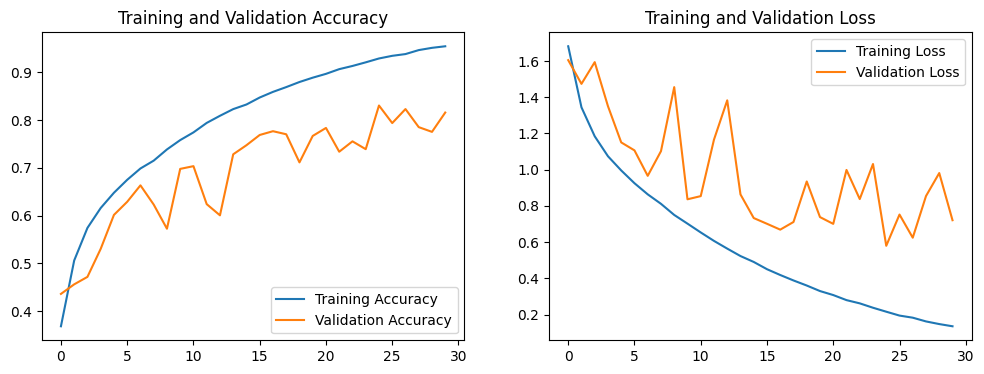

In [8]:
plot_history(history.history)

In [9]:
# save the model and history
modern_alexnet.save('modern_alexnet_cifar10_model.h5')
import pickle
with open('modern_alexnet_cifar10_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

/home/rover/miniconda3/envs/tf-best/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
